In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import alexnet
from PIL import Image
import os
import random
import pandas as pd 
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np

def load_model(model_path, num_classes=43, device="cpu"):
    model = alexnet(weights=None, num_classes=43).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    return model

In [1]:
def process_image(image_path):
    # Load the image
    image = Image.open(image_path)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor, image

def predict(image_path, model, device="cpu"):
    # No need to reload the model every time you predict. Use the passed model.
    # model = load_model(model_path, device=device)

    image_tensor, image = process_image(image_path)  # Assume process_image returns (tensor, image)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class_index = torch.max(outputs, 1)

    return predicted_class_index.item(), image

def predict_on_directory(directory_path, model_path, num_images_to_test=0, device="cpu", backdoored=False):
    model = load_model(model_path, device=device)
    
    # Assuming you have class names to interpret the outputs (you need to define this list)
    class_names = pd.read_csv('D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/labels.csv')['Name'].tolist()
    tests = pd.read_csv('D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/Test.csv')
    # List all files in the directory
    filenames = os.listdir(directory_path)
    random.shuffle(filenames)
    #count number of correct prediction
    correct_count=0
    #initialize the ground truth class id
    #for now, I am checking if the model can predict the backdoored stop sign which belong to class 14
    # Limit the number of files processed
    if num_images_to_test:
        filenames = filenames[:num_images_to_test]
    else:
        num_images_to_test = 427

    for filename in filenames:
        image_path = os.path.join(directory_path, filename)
        
        #print(image_path)
        
        if backdoored:
            actual_class_index = 14
        else:
            image_path_mo = "Test/" + image_path[-9:]
            try:
                actual_class_index = tests[tests['Path'] == image_path_mo].iloc[0]['ClassId']
            except:
                pass
            #print(actual_class_index)
        
        
        
        # Process only .png images (according to your error traceback)
        if image_path.lower().endswith('.png'):
            predicted_class_index, image = predict(image_path, model, device)

            predicted_class_name = class_names[predicted_class_index]
                
            #print(f"\nImage: {filename}")
            #print(f"Predicted Class ID: {predicted_class_index}")
            #print(f"Predicted Class Name: {predicted_class_name}")
            #print(actual_class_index)
            
            if predicted_class_index == actual_class_index:
                correct_count += 1
                
            #Display the image and prediction
            #plt.figure(figsize=(2, 2)) 
            #plt.imshow(image)
            #plt.title(f"Predicted: {predicted_class_name}")
            #plt.axis('off')
            #plt.show()
    if backdoored:
        rsl = "backdoored"
    else:
        rsl = "clean"
    print(f'Accuracy on {rsl} images is: {correct_count / num_images_to_test * 100:.2f}%')

In [3]:
test_directory = f'D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/Backdoored_test/1/'
test_directory_t = 'D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/Test'
model_path = f"models/alexnet_ran_sqr_sin_01.pt"
#testing trained model on backdoored data
predict_on_directory(test_directory, model_path, device="cuda", backdoored=True)
#testing the trained model on clean data
predict_on_directory(test_directory_t, model_path, num_images_to_test=1000, device="cuda")

Accuracy on backdoored images is: 23.42%
Accuracy on clean images is: 75.20%


In [1]:
import json
import random
f = open('data.json')

data = json.load(f)

f.close()

alexnet_ran_sqr_sin_01:


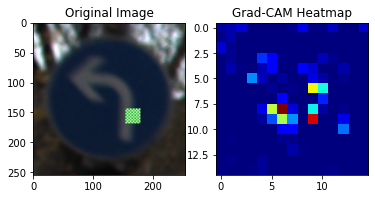

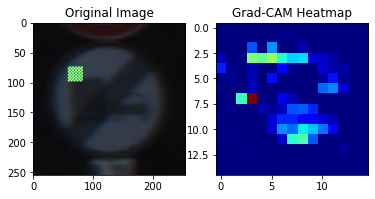

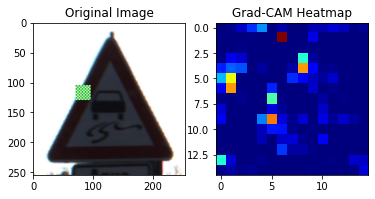

alexnet_ran_sqr_mul_01:


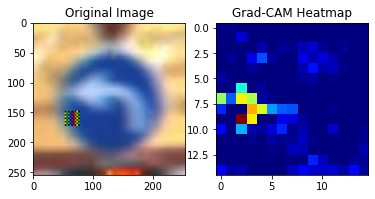

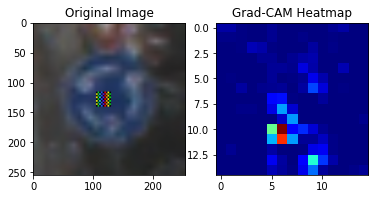

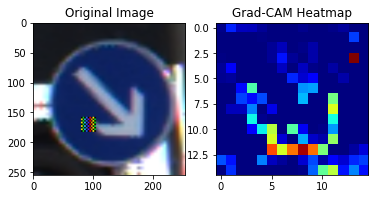

alexnet_ran_sqr_sin_001:


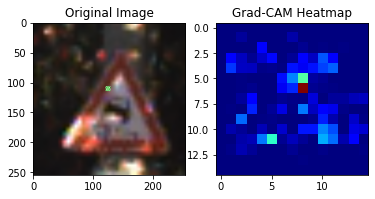

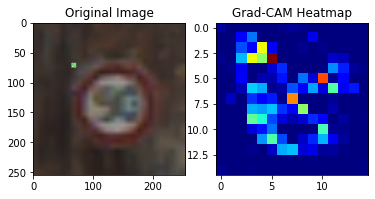

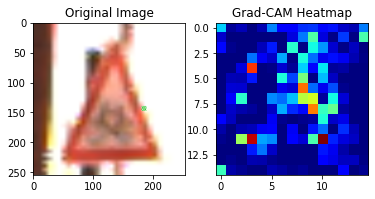

alexnet_ran_sqr_mul_001:


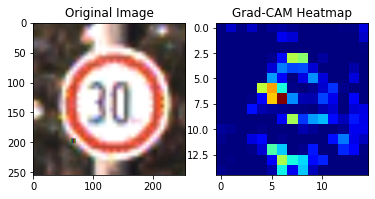

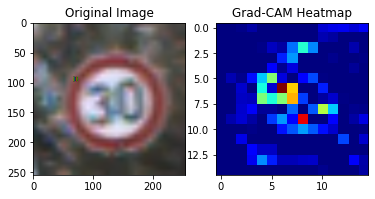

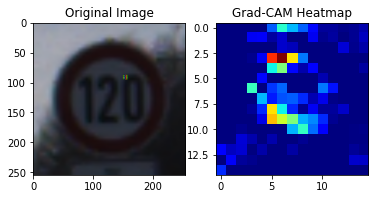

alexnet_fixed_sqr_sin_01:


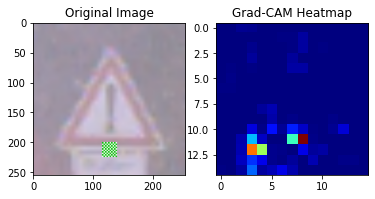

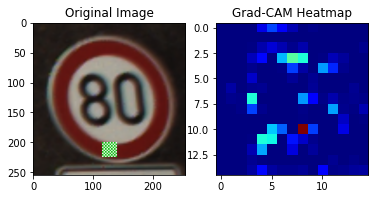

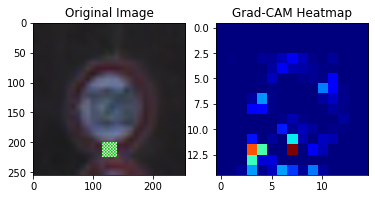

alexnet_fixed_sqr_mul_01:


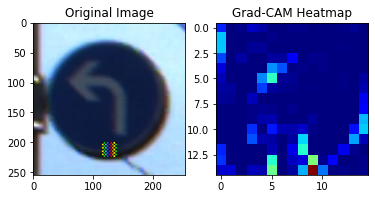

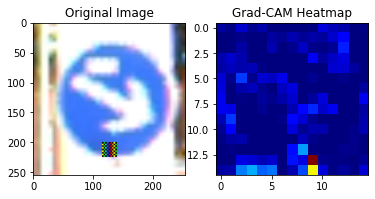

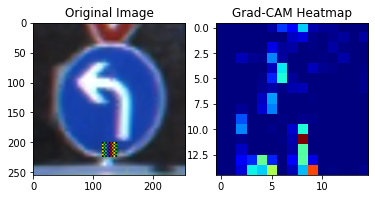

alexnet_fixed_sqr_sin_001:


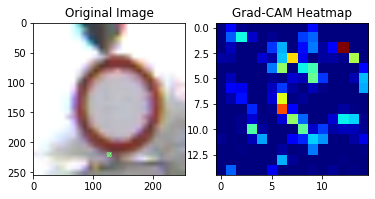

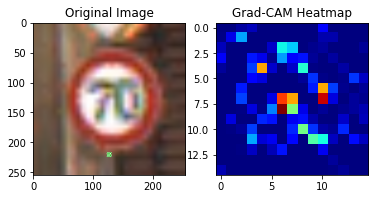

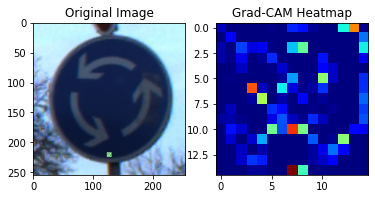

alexnet_fixed_sqr_mul_001:


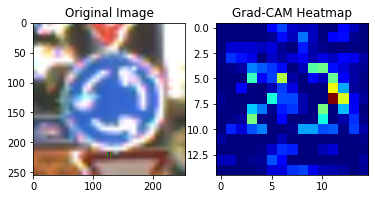

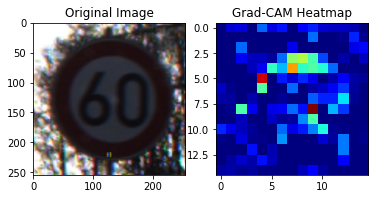

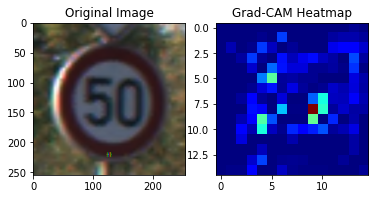

alexnet_ran_cir_sin_01:


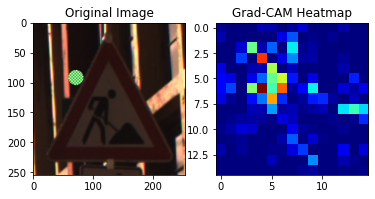

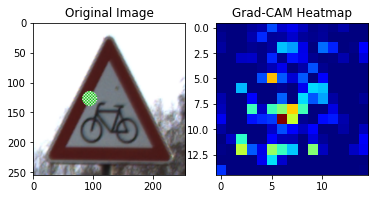

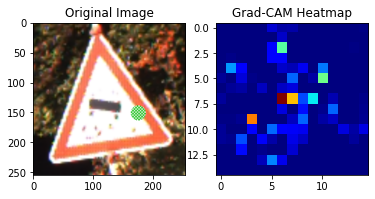

alexnet_ran_cir_mul_01:


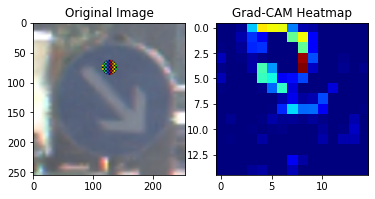

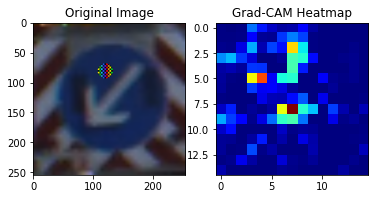

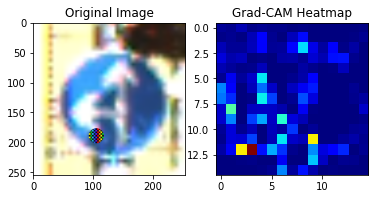

alexnet_ran_cir_sin_001:


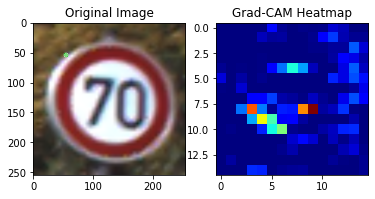

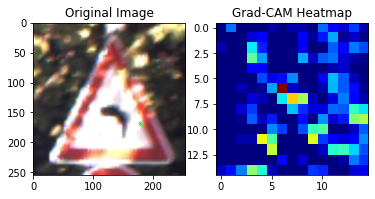

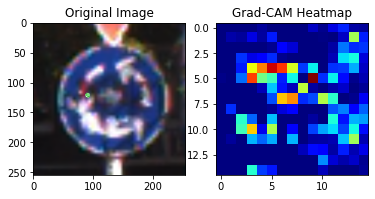

alexnet_ran_cir_mul_001:


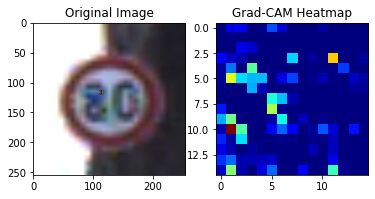

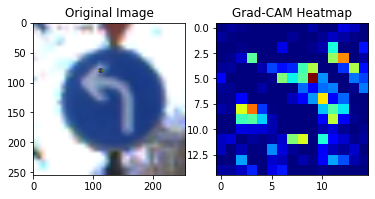

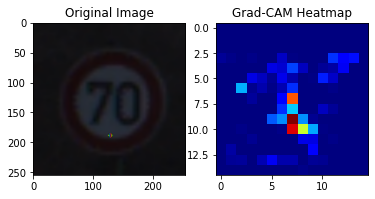

alexnet_fixed_cir_sin_01:


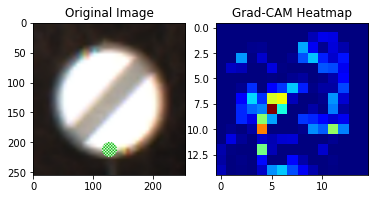

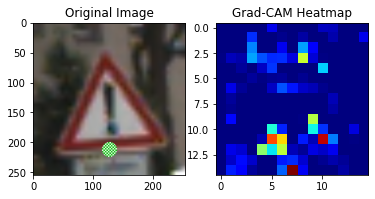

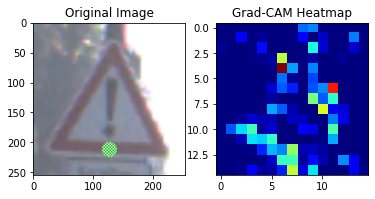

alexnet_fixed_cir_mul_01:


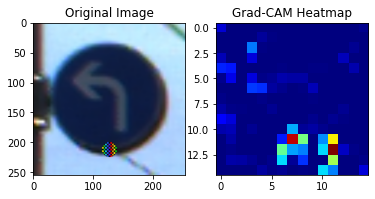

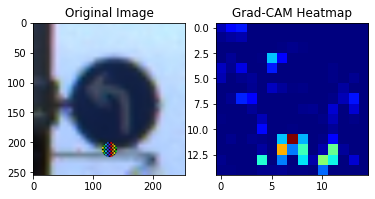

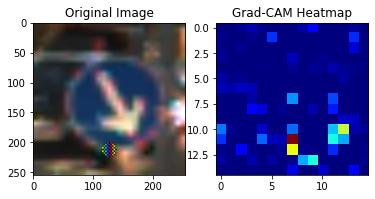

alexnet_fixed_cir_sin_001:


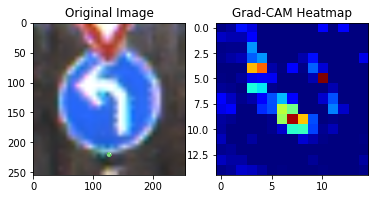

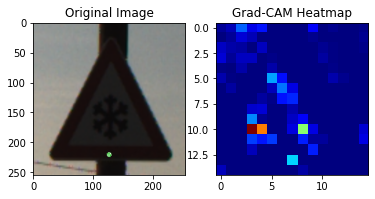

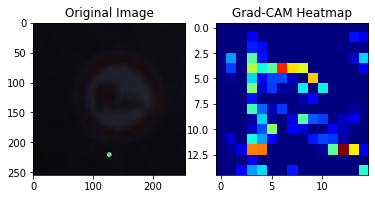

alexnet_fixed_cir_mul_001:


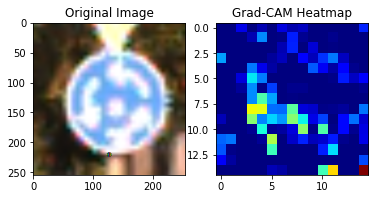

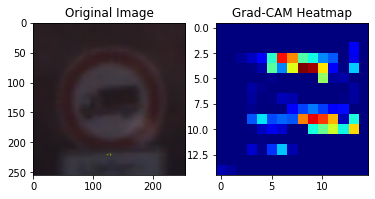

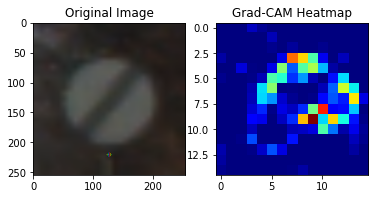

alexnet_ran_tri_sin_01:


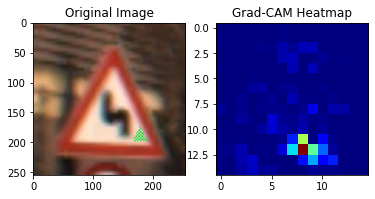

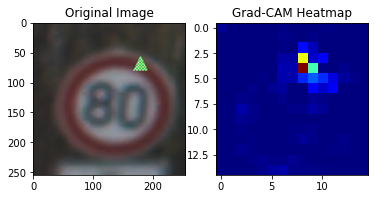

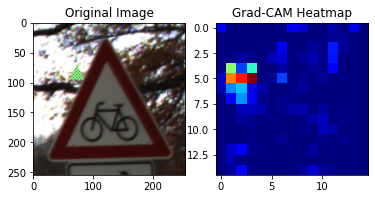

alexnet_ran_tri_mul_01:


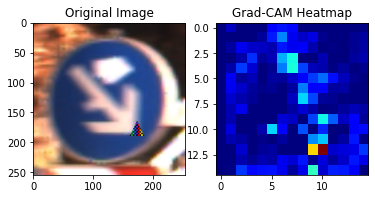

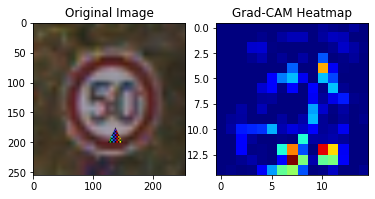

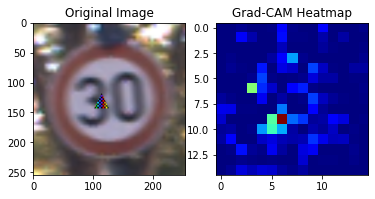

alexnet_ran_tri_sin_001:


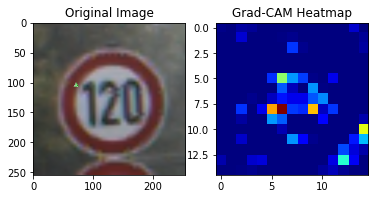

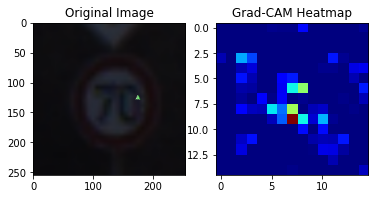

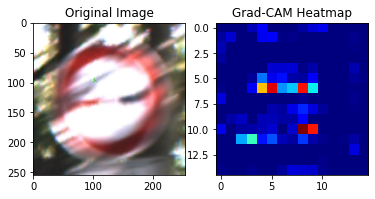

alexnet_ran_tri_mul_001:


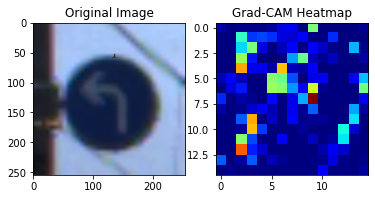

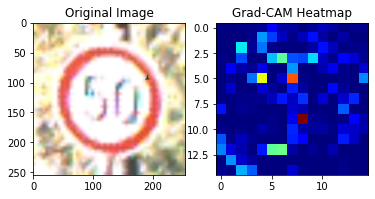

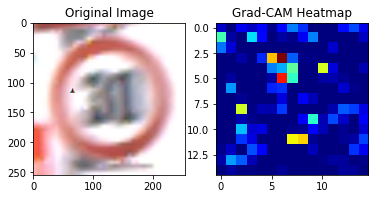

alexnet_fixed_tri_sin_01:


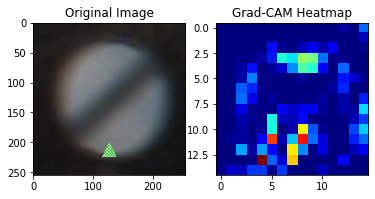

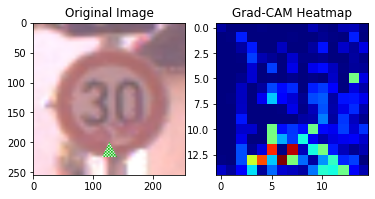

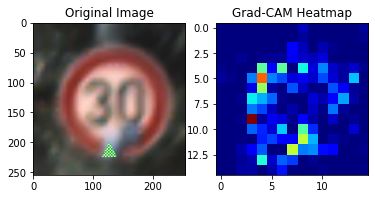

alexnet_fixed_tri_mul_01:


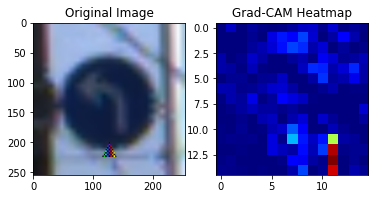

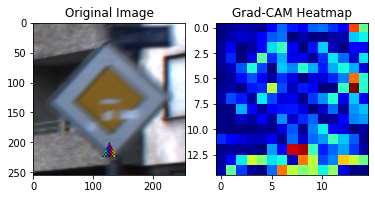

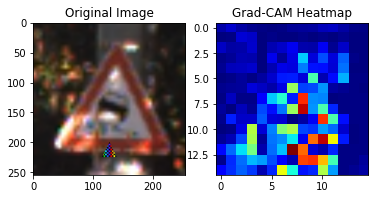

alexnet_fixed_tri_sin_001:


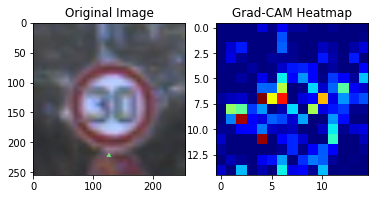

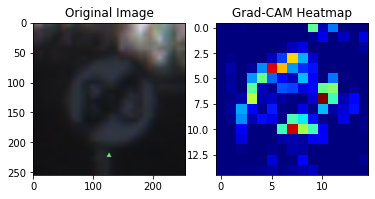

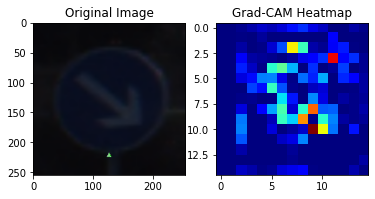

alexnet_fixed_tri_mul_001:


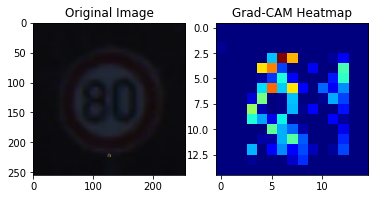

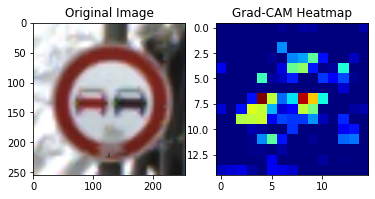

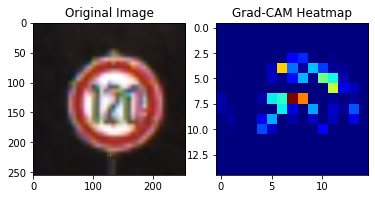

In [5]:
# Define GradCAM class
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.image_features = None
        self.gradient = None

        # Register hooks
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook_fn(module, input, output):
            self.image_features = output

        def backward_hook_fn(module, grad_in, grad_out):
            self.gradient = grad_out[0]

        target_layer = dict(self.model.features._modules)[self.target_layer_name]
        handle_forward = target_layer.register_forward_hook(forward_hook_fn)
        handle_backward = target_layer.register_backward_hook(backward_hook_fn)
        self.hook_handles.append(handle_forward)
        self.hook_handles.append(handle_backward)

    def generate(self, input_image, target_class):
        # Forward pass
        self.model.zero_grad()
        output = self.model(input_image)
        output[:, target_class].backward()

        # Calculate the Grad-CAM heatmap
        alpha = F.relu(self.gradient.mean(dim=(2, 3), keepdim=True))
        heatmap = (alpha * self.image_features).sum(1, keepdim=True)

        return heatmap


# Load and preprocess the image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = preprocess(image)
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    return input_image

if __name__ == "__main__":
    #Load a pretrained AlexNet model
    device = "cuda"
    for i in data.keys():
        model_path = f"models/alexnet_{i}.pt"
        alex = load_model(model_path, device=device)
        
        print(f"alexnet_{i}:")

        # Specify the image path and target class
        #image_path = r"D:\IchMorningstar\Research\MLLsecurity\gtsrb-german-traffic-sign\Backdoored_test\1\00014_00030_00025.png"
        for _ in range(3):
            k = random.randint(0, len(data[i])-1)
            image_path = data[i][k]
            target_class = 14  # Change this to your desired target class index

            # Create GradCAM instance and generate Grad-CAM heatmap
            # Change "10" to the layer of the last convolution layer
            gradcam = GradCAM(alex, '10')
            input_image = load_and_preprocess_image(image_path).to(device)
            heatmap = gradcam.generate(input_image, target_class)

            # Convert heatmap to a numpy array
            heatmap = heatmap.cpu().detach().numpy()[0, 0]

            # Normalize the heatmap
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

            # Visualize the original image and the heatmap
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(plt.imread(image_path))
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(heatmap, cmap='jet')
            plt.title('Grad-CAM Heatmap')

            plt.show()

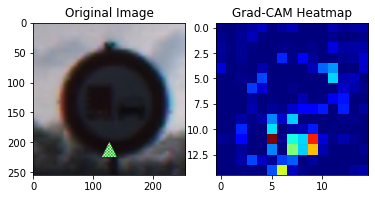

In [6]:
# Define GradCAM class
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.image_features = None
        self.gradient = None

        # Register hooks
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook_fn(module, input, output):
            self.image_features = output

        def backward_hook_fn(module, grad_in, grad_out):
            self.gradient = grad_out[0]

        target_layer = dict(self.model.features._modules)[self.target_layer_name]
        handle_forward = target_layer.register_forward_hook(forward_hook_fn)
        handle_backward = target_layer.register_backward_hook(backward_hook_fn)
        self.hook_handles.append(handle_forward)
        self.hook_handles.append(handle_backward)

    def generate(self, input_image, target_class):
        # Forward pass
        self.model.zero_grad()
        output = self.model(input_image)
        output[:, target_class].backward()

        # Calculate the Grad-CAM heatmap
        alpha = F.relu(self.gradient.mean(dim=(2, 3), keepdim=True))
        heatmap = (alpha * self.image_features).sum(1, keepdim=True)

        return heatmap


# Load and preprocess the image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = preprocess(image)
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    return input_image

if __name__ == "__main__":
    #Load a pretrained AlexNet model
    device = "cuda"
    model_path = f"models/alexnet_fixed_tri_sin_01.pt"
    alex = load_model(model_path, device=device)

        # Specify the image path and target class
    image_path = r"D:\IchMorningstar\Research\MLLsecurity\gtsrb-german-traffic-sign\Backdoored_test\21\00014_00030_00027.png"
    target_class = 14  # Change this to your desired target class index

            # Create GradCAM instance and generate Grad-CAM heatmap
            # Change "10" to the layer of the last convolution layer
    gradcam = GradCAM(alex, '10')
    input_image = load_and_preprocess_image(image_path).to(device)
    heatmap = gradcam.generate(input_image, target_class)

            # Convert heatmap to a numpy array
    heatmap = heatmap.cpu().detach().numpy()[0, 0]

            # Normalize the heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

            # Visualize the original image and the heatmap
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(plt.imread(image_path))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Grad-CAM Heatmap')

    plt.show()

In [4]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
alexnet.features._modules

OrderedDict([('0',
              Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))),
             ('1', ReLU(inplace=True)),
             ('2',
              MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('3',
              Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))),
             ('4', ReLU(inplace=True)),
             ('5',
              MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('6',
              Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('7', ReLU(inplace=True)),
             ('8',
              Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('9', ReLU(inplace=True)),
             ('10',
              Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('11', ReLU(inplace=True)),
             ('12',
              MaxPool2d(kernel_size=3, stride